# Homework 2 Exercise 1
Construct a linear regression of weight as predicted by height, using the adults (age 18 or greater) from the Howell1 dataset. The heights listed below were recorded in the !Kung census, but weights were not recorded for these individuals. Provide predicted weights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

| Individual | height | expected weight  | 89% interval  |
|---|---|---|---|
| 1 | 140 |   |   |
| 2 | 160 |   |   |
| 3 | 175 |   |   |

In [1]:
using StatsPlots
using StatisticalRethinking: sr_datadir, PI
using StatisticalRethinkingCommon
using Statistics, StatsBase
import CSV
using DataFrames
using Gen, Distributions

In [2]:
@time data = CSV.read(sr_datadir("Howell1.csv"), DataFrame)

 10.040646 seconds (3.00 M allocations: 136.131 MiB, 99.97% compilation time)


,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


In [3]:
adults = data[data.age .>= 18 , :]

,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


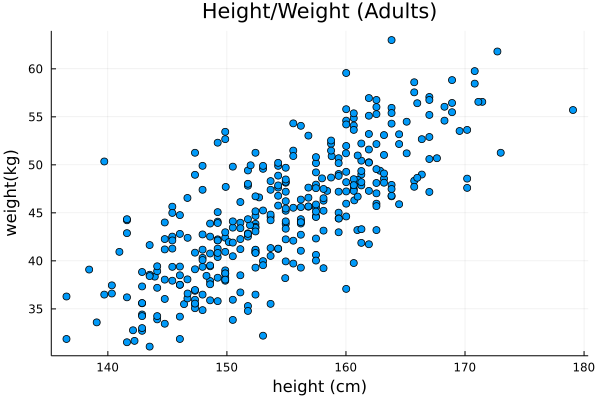

In [4]:
@df adults plot(:height, :weight, seriestype=:scatter, title="Height/Weight (Adults)", xlabel="height (cm)", ylabel="weight(kg)", legend=false)

In [5]:
dt = standardize_column!(adults, :height, scale=false)

ZScoreTransform{Float64, Vector{Float64}}(1, 1, [154.59709261363633], Float64[])

In [6]:
@gen function adults_height_weight_model(heights)
    a ~ normal(40., 7.5) # somewhere around 40, in kg
    b ~ gamma(1, 3.) # how does weight scale with height, in kg/cm. However, don't forget that height was normalized.
    noise ~ gamma(1., 1.) # how far does the regression stray from reality
    
    function f(height)
        return a + b * height
    end
    
    for (i,height) in enumerate(heights)
        {(:y, i)} ~ normal(f(height), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##adults_height_weight_model#280", Bool[0], false)

Check how the priors are distributed:

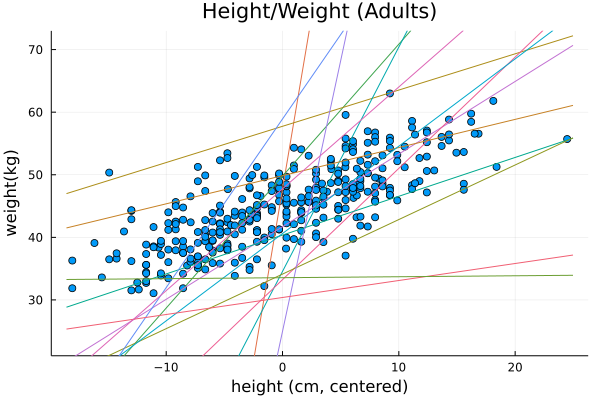

In [7]:
@df adults plot(:height, :weight, seriestype=:scatter, title="Height/Weight (Adults)", xlabel="height (cm, centered)", ylabel="weight(kg)", legend=false)
priors = [adults_height_weight_model(()) for _ in 1:15]
test_xs = range(minimum(adults.height)-0.5, maximum(adults.height)+0.5, length=1000)
plot!(test_xs, [f.(test_xs) for f in priors], legend=false)
plot!(ylim=(minimum(adults.weight) - 10, maximum(adults.weight) + 10))

In [8]:
observations = Gen.choicemap()
for (i,weight) in enumerate(adults.weight)
    observations[(:y, i)] = weight
end

num_samples=500
num_traces=100

@time traces = [Gen.importance_resampling(adults_height_weight_model, (adults.height,), observations, num_samples)[1] for _ in 1:num_traces]
as = Gen.get_value.(Gen.get_choices.(traces), :a)
bs = Gen.get_value.(Gen.get_choices.(traces), :b)
noises = Gen.get_value.(Gen.get_choices.(traces), :noise)
a = mean(as)
b = mean(bs)
noise = mean(noises);
a, b, noise

  8.229839 seconds (225.99 M allocations: 8.368 GiB, 9.99% gc time, 5.56% compilation time)


(44.60738133007337, 0.6118193834405761, 3.8557304386867277)

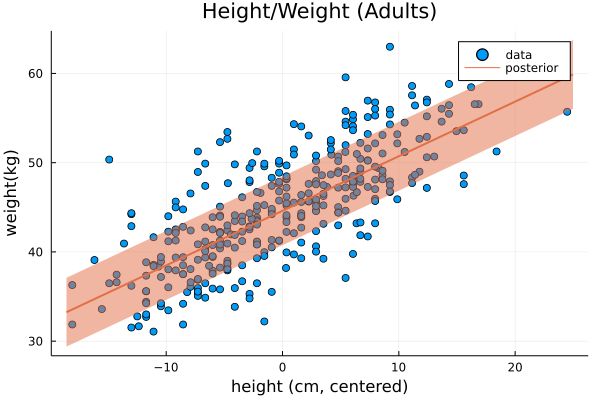

In [9]:
@df adults plot(:height, :weight, seriestype=:scatter, title="Height/Weight (Adults)", xlabel="height (cm, centered)", ylabel="weight(kg)", labels="data")
plot!(test_xs, (@. a + b * test_xs), linewidth=2., ribbon=noise, labels="posterior")

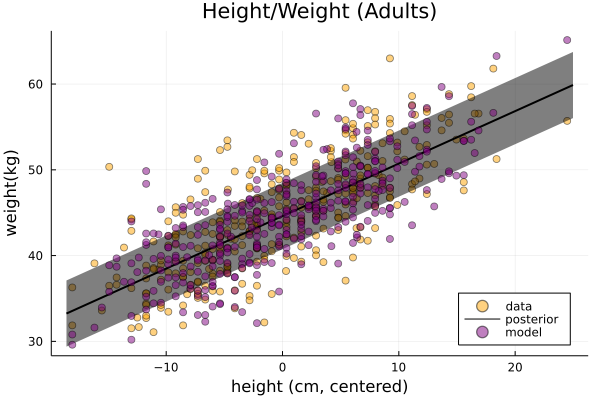

In [10]:
@df adults plot(:height, :weight, seriestype=:scatter, color=:orange, alpha=1/2, title="Height/Weight (Adults)", xlabel="height (cm, centered)", ylabel="weight(kg)", labels="data", legend=:bottomright)
plot!(test_xs, (@. a + b * test_xs), color=:black, ribbon=noise, labels="posterior", linewidth=2.)
test_predictions = @. rand(Normal(a + b * adults.height, noise))
plot!(adults.height, test_predictions, seriestype=:scatter, color=:purple, alpha=1/2, label="model")

In [11]:
to_predict = [140.,160.,175.]
StatsBase.transform!(dt, to_predict)
to_predict = reshape(to_predict, (1,length(to_predict)))

1×3 Matrix{Float64}:
 -14.5971  5.40291  20.4029

In [12]:
to_predict = repeat(to_predict, outer = 1000)
@time predictions = @. rand(Normal(a + b * to_predict, noise))

  0.077652 seconds (395.20 k allocations: 21.166 MiB, 98.14% compilation time)


1000×3 Matrix{Float64}:
 41.8026  43.6093  56.0853
 42.6636  39.3875  54.952
 33.7038  44.4137  56.0738
 38.1188  44.4161  60.566
 40.9039  42.54    54.7297
 30.9484  48.811   61.4822
 39.6482  48.978   52.9858
 35.7153  48.2159  51.3418
 31.9967  49.3249  58.2075
 40.5889  50.7932  60.8757
 32.9799  49.9756  53.183
 30.94    47.2799  53.695
 35.2722  53.2718  60.8985
  ⋮                
 40.0287  46.5668  63.3541
 32.9912  47.3314  54.1862
 34.2925  48.9529  56.0788
 36.055   45.8592  55.6893
 41.757   43.2805  53.5721
 30.0025  45.3807  56.5261
 32.2479  43.6638  59.6181
 35.2745  54.3912  60.2316
 34.3248  46.8158  60.0319
 41.413   53.4846  59.562
 35.0224  45.0442  62.8882
 36.9397  49.8794  51.1588

In [13]:
ew1, ew2, ew3 = round.(mean(predictions, dims=1), digits=2)

1×3 Matrix{Float64}:
 35.49  47.79  57.1

In [14]:
i1 = round.(PI(predictions[:,1]), digits=2)
i2 = round.(PI(predictions[:, 2]), digits=2)
i3 = round.(PI(predictions[:, 3]), digits=2)
i1, i2, i3

([29.28, 41.84], [41.48, 54.24], [50.76, 63.54])

In [15]:
@info "\n| Individual | height | expected weight |  89% interval  |
|------------|--------|-----------------|----------------|
|          1 |    140 |           $ew1 | $i1 |
|          2 |    160 |           $ew2 | $i2 |
|          3 |    175 |           $ew3 | $i3 |"

┌ Info: 
│ | Individual | height | expected weight |  89% interval  |
│ |------------|--------|-----------------|----------------|
│ |          1 |    140 |           35.49 | [29.28, 41.84] |
│ |          2 |    160 |           47.79 | [41.48, 54.24] |
│ |          3 |    175 |           57.1 | [50.76, 63.54] |
└ @ Main In[15]:1
